In [1]:
import os
import pandas as pd
import numpy as np
import ast
from collections import Counter
import warnings
warnings.filterwarnings('ignore')
#visualisation
import seaborn as sn
import matplotlib as mpl 
import matplotlib.cm as cm 
import matplotlib.pyplot as plt
# NLP
from nltk.corpus import stopwords
import string
import spacy
from sklearn.feature_extraction.text import CountVectorizer # bag of words
# Machine Learning
from sklearn.pipeline import Pipeline
from sklearn.metrics import accuracy_score, roc_auc_score, confusion_matrix, roc_auc_score, classification_report
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import GridSearchCV

### Read Data

This data comes from https://www.kaggle.com/c/learn-ai-bbc/data

In [2]:
home_path = os.path.expanduser("~")
fp = f'{home_path}/git/30-days-of-NLP/notebooks/Data/bbc-text.csv'
df = pd.read_csv(fp)
df.head(2)

,category,text
0,tech,tv future in the hands of viewers with home th...
1,business,worldcom boss left books alone former worldc...


### Exploratory Data Analysis

sport            0.229663
business         0.229213
politics         0.187416
tech             0.180225
entertainment    0.173483
Name: category, dtype: float64

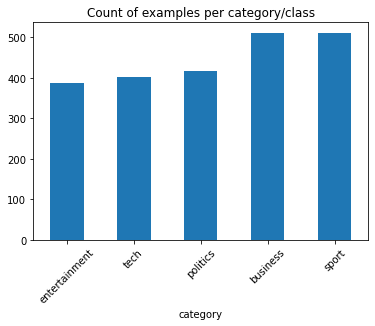

In [3]:
(f'Number of documents in dataset: {len(df)}')
display(df["category"].value_counts()/df.shape[0]) # Class distribution in the dataset
df.groupby('category').size().sort_values().plot.bar()
plt.title('Count of examples per category/class')
plt.xticks(rotation=45);

Business and Sport are best represented in the dataset.

### How good is a baseline logistic regression model on the raw dataset?

In [26]:
def plot_confusion_matrix(cm, classes, title):
    cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis] # normalise
    sn.heatmap(cm, annot=True, fmt='.2', cmap='Blues', xticklabels=classes, yticklabels=classes)
    plt.ylabel('True label',fontsize=15)
    plt.xlabel('Predicted label',fontsize=15)
    plt.title(title)
    plt.show()

CPU times: user 12.8 s, sys: 14.6 s, total: 27.3 s
Wall time: 4.24 s
Accuracy Training Data:  1.0


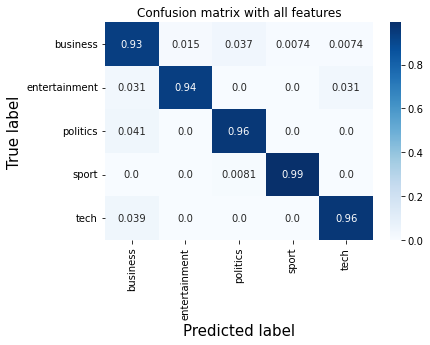

Accuracy Test Data:  0.9569120287253142


In [13]:
X_train, X_test, y_train, y_test = train_test_split(df['text'], df['category'], 
                                                    test_size=0.25, random_state=42)

log_reg = Pipeline([('bow', CountVectorizer(binary=True)), 
                   ('clf', LogisticRegression(random_state=42))])
%time log_reg.fit(X_train, y_train)
y_pred_training_data = log_reg.predict(X_train)
print(f"Accuracy Training Data: ", accuracy_score(y_true=y_train, y_pred=y_pred_training_data))

# Test Model
y_pred = log_reg.predict(X_test) # make class predictions for X_test
classes = log_reg.classes_
cm = confusion_matrix(y_true=y_test, y_pred=y_pred)
plot_confusion_matrix(cm, classes, 'Confusion matrix with all features')
print("Accuracy Test Data: ", accuracy_score(y_true=y_test, y_pred=y_pred))

### Preprocessing
lowercase strings, remove digits, punctuation, stopwords, and lemmatise.

When saving pandas dataframes as csv the list object is stored as a string, therefore the `ast.literal_eval` function converts it back to a list. Save as pickle to keep data types.

In [4]:
# Install the spaCy language model
# ! python -m spacy download en_core_web_sm

This script take ~30mins the first time.

In [23]:
%%time
mystopwords = set(stopwords.words('english'))
nlp = spacy.load('en_core_web_sm')
def clean(doc):
    doc = "".join([char for char in doc if char not in string.punctuation and not char.isdigit()]) # remove punctuation and numbers
    doc = " ".join([token.lower() for token in doc.split() if token not in mystopwords])
    doc = " ".join([w.lemma_ for word in doc.split() for w in nlp(word)])
    return doc

df_preprop_fp = f'{home_path}/git/30-days-of-NLP/notebooks/Data/bbc-text-preprocessed.csv'
if not os.path.exists(df_preprop_fp):
    df['prepro'] = df['text'].apply(clean)
    df.to_csv(df_preprop_fp, index=False)
    
else: # load preprocessed(lemmatisated) dataframe
    df = pd.read_csv(df_preprop_fp)
    df['prepro'] = df['prepro'].apply(ast.literal_eval) # convert str to list

CPU times: user 28min 1s, sys: 871 ms, total: 28min 1s
Wall time: 28min 2s


In [24]:
display(df.head(2))

,category,text,prepro
0,tech,tv future in the hands of viewers with home th...,tv future hand viewer home theatre system plas...
1,business,worldcom boss left books alone former worldc...,worldcom boss leave book alone former worldcom...


### Model Training & Testing

CPU times: user 6.37 s, sys: 6.47 s, total: 12.8 s
Wall time: 1.97 s
Accuracy Training Data:  1.0


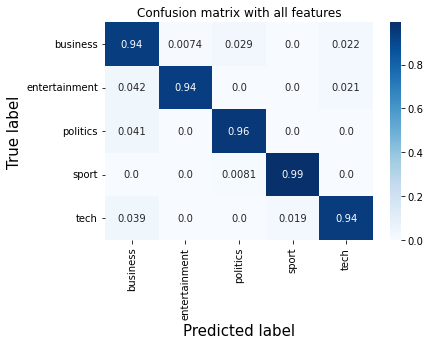

Accuracy Test Data:  0.9551166965888689


In [27]:
X_train, X_test, y_train, y_test = train_test_split(df['prepro'], df['category'], 
                                                    test_size=0.25, random_state=42)

log_reg = Pipeline([('bow', CountVectorizer(binary=True)), 
                   ('clf', LogisticRegression(random_state=42))])
%time log_reg.fit(X_train, y_train)
y_pred_training_data = log_reg.predict(X_train)
print(f"Accuracy Training Data: ", accuracy_score(y_true=y_train, y_pred=y_pred_training_data))

# Test Model
y_pred = log_reg.predict(X_test) # make class predictions for X_test
classes = log_reg.classes_
cm = confusion_matrix(y_true=y_test, y_pred=y_pred)
plot_confusion_matrix(cm, classes, 'Confusion matrix with all features')
print("Accuracy Test Data: ", accuracy_score(y_true=y_test, y_pred=y_pred))

### Vectorisation of dataset
Bag of Words

In [19]:
count_vect = CountVectorizer(binary=True)
bow_rep = count_vect.fit_transform(df['prepro'].astype(str))
# create dataframe
df_bow = pd.DataFrame(bow_rep.toarray(), columns=count_vect.get_feature_names())
print(f'There are {len(df_bow.columns)} tokens in the bag of words')
df_bow.head(1)

There are 23431 tokens in the bag of words


,aa,aaa,aaas,aac,aadc,aaliyah,aaltra,aamir,aan,aara,...,zoom,zooropa,zornotza,zorro,zubair,zuluaga,zurich,zuton,zvonareva,zvyagintsev
0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


Each row in the bag of words refers to a document, so the length of bag of words and the labelled data should be the same. So the 0 index in df_bow is the 0 index in the df. 

In [20]:
len(df_bow), len(df)

(2225, 2225)

### Modelling

Split the data into training and testing with sklearn

`random_state` is for reproducibility

In [21]:
data, labels = df_bow, df['category']
X_train, X_test, y_train, y_test = train_test_split(data, labels, 
                                                    test_size=0.25, random_state=42)
print(f'Training Data: {X_train.shape[0]}')
print(f'Testing Data: {X_test.shape[0]}')

Training Data: 1668
Testing Data: 557


#### logisitic regression model

Logistic regression is an example of a discriminative classifier and is commonly used in text classification, as a baseline in research, and as an MVP in real-world industry scenarios. Logistic regression “learns” the weights for individual features based on how important they are. The goal of logistic regression is to learn a linear separator between classes in the training data with the aim of maximizing the probability of the data. This “learning” of feature weights and probability distribution over all classes is done through a function called “logistic” function, and (hence the name) logistic regression. (Vajjala et al, Practical Natural Language Processing)


GridSearchCV: hyperparameter tuning in order to determine the optimal values for a given model

Defaults: `C = 10`, `solver = 'lbfgs`, `max_iter = 100`

In [24]:
%%time
param_grid = {"C": np.logspace(-1,2,4),
             "solver": ['lbfgs', 'newton-cg']}
clf = LogisticRegression(random_state=42, class_weight='balanced')
grid = GridSearchCV(clf, param_grid, cv=10)
grid.fit(X_train,y_train)

print(f'Accuracy {grid.best_score_}')
print(f'Tuned hpyerparameters : {grid.best_params_}')

KeyboardInterrupt: 

In [23]:
cv_df = pd.DataFrame(clf_cv.cv_results_)
cv_df.T.sample(5)

NameError: name 'clf_cv' is not defined

In [19]:
print('Model Training time:')
log_reg = LogisticRegression() # instantiate a logistic regression model
%time log_reg.fit(X_train, y_train) # train the model(timing it with an IPython "magic command")
y_pred_training_data = log_reg.predict(X_train) # make class predictions for X_train
print(accuracy_score(y_true=y_train, y_pred=y_pred_training_data))

Model Training time:
CPU times: user 48.7 s, sys: 18.4 s, total: 1min 7s
Wall time: 9.69 s
1.0


100% accuracy on the training data set. The model has fit perfectly to the training data. 

Has it overfit to the data? To make sure we use the model to predict on the test dataset. 

### Accuracy Assessment

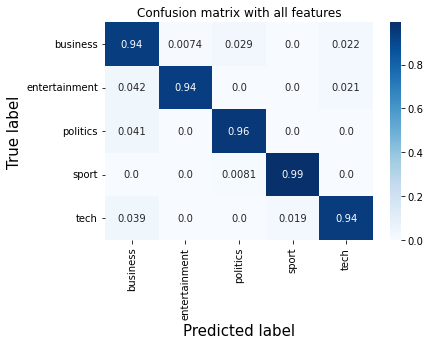

Accuracy:  0.9551166965888689


In [25]:
def plot_confusion_matrix(cm, classes, title):
    cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis] # normalise
    sn.heatmap(cm, annot=True, fmt='.2', cmap='Blues', xticklabels=classes, yticklabels=classes)
    plt.ylabel('True label',fontsize=15)
    plt.xlabel('Predicted label',fontsize=15)
    plt.title(title)
    plt.show()

y_pred = log_reg.predict(X_test) # make class predictions for X_test
classes = log_reg.classes_
cm = confusion_matrix(y_true=y_test, y_pred=y_pred)
plot_confusion_matrix(cm, classes, 'Confusion matrix with all features')
print("Accuracy: ", accuracy_score(y_true=y_test, y_pred=y_pred))

The test data is unseen and therefore provides the final quality assurance for our model. 

That way we can run this model on future news data (that has no labels) and know that it will have an accuracy of around 95%. 

The model mostly was confused by business and entertainment and tech with entertainment. Tech and entertainment are the least represented classes in the dataset.

#### Which ones did it get wrong?

In [53]:
incorrect_predictions = np.where(y_test != y_pred)
idxs = y_test.index
for tuple_list in incorrect_predictions:
    for i in tuple_list:
        print(f'\nPredicted category: {y_pred[i]}')
        print(f'\nTrue category: {df.iloc[idxs]["category"].iloc[i]}')
        print(f'\nData: {df.iloc[idxs]["text"].iloc[i]}')
        print('###'*20)


Predicted category: tech

True category: business

Data: id theft surge hits us consumers almost a quarter of a million us consumers complained of being targeted for identity theft in 2004  official figures suggest.  the federal trade commission said two in five of the 635 173 reports it had from consumers concerned id fraud. id theft occurs when criminals use someone else s personal information to steal credit or commit other crimes. internet auctions were the second biggest source of fraud complaints  comprising 16% of the total. the total cost of fraud reported by consumers was $546m (£290m).  the report marks the fifth year in a row in which identity fraud has topped the table. the biggest slice of the 246 570 id fraud cases reported - almost 30% - concerned abuses of people s credit. misusing someone s identity to claim new credit cards or loans comprised 16.5% of the total  with almost 12% coming from false claims on existing credit. another 18% came from attempts to rip off peo

The incorrect predictions are fair e.g. 
- predicted sport when the true category is tech because the news article is talking about a game called football manager.
- predicted politics when the true category is business because the new article discusses pensions, living standards and policy. 

It is worth noting that while the NLP model does perform well, the data that trained the model is time-specific e.g. technology words will change, politicians will come and go, new markets will emerge in business, news sporting heroes will win games and new actors/films/music will be popular. For a news NLP model to be successful it would most likely need continuous training. 